<a href="https://colab.research.google.com/github/Akshaya0909/enigma/blob/master/recommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/Akshaya0909/enigma.git

Cloning into 'enigma'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 75 (delta 24), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (75/75), done.


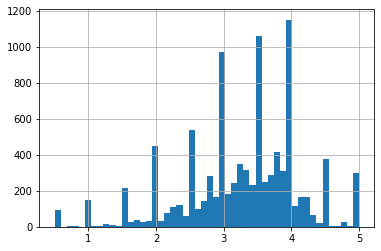

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/ratings.csv',sep=',')
df_ratings = pd.read_csv('/content/ratings.csv',sep=',',usecols=["userId","movieId","rating"])
movies = pd.read_csv('/content/movies.csv',usecols=["movieId","title"])
df = pd.merge(df,movies,on='movieId')
df.head()
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head()
ratings['number_of_ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings.head()

# To find the most used range of ratings
ratings['rating'].hist(bins=50)



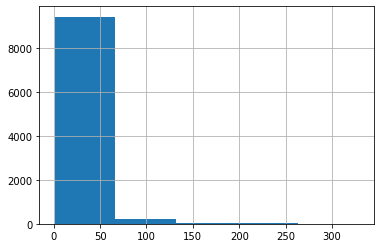

In [2]:
# Plotting the number of ratings a movie gets
ratings['number_of_ratings'].hist(bins=5)

In [7]:
# To convert the dataframe into a sparse matrix placing 0 under movie that's not rated by a particular user, else fill the rating
from scipy.sparse import csr_matrix
df_movie_features = df_ratings.pivot(index='movieId',columns='userId',values='rating').fillna(0)
matrix_movie_features = csr_matrix(df_movie_features.values)
df_movie_features.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,4.5,3.5,4.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,5.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,3.0,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.5,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,2.5,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# We need a measure of distance to find K nearest neighbours. We cannot use euclidean distance at higher dimensions since almost all points are a equal distance in higher dimensions. Thus we resort to other methods like cosine similarity orlocality sensitive hashing. In our case, we use cosine similarity
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine',algorithm='brute',n_neighbors=20,n_jobs=-1)
model_knn.fit(matrix_movie_features)


NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [0]:
# The df rows are defined by movie ids. So we pick a random row index, i.e., a random movie and find its nearest neighbors
import numpy as np
query_movie = np.random.choice(df_movie_features.shape[0])
# Change n_neighbors based on how many movie recommendations are needed
distance,indices = model_knn.kneighbors(df_movie_features.iloc[query_movie,:].values.reshape(1,-1),n_neighbors=16)

In [72]:
# Printing the movies recommended if a given user has watched a particular movie specified by query movie
#movie_name = pd.read_csv('/content/movies.csv',usecols=["title"])
#movie_id = pd.read_csv('/content/movies.csv',usecols=["movieId"])
import pandas as pd
map = pd.Series(movies.title.values,index=movies.movieId).to_dict()
for i in range(0,len(distance.flatten())):
  if i==0:
    print('Recommendations for {0} are:\n'.format(map[df_movie_features.index[query_movie]]))
  else:
    print('{0}:{1} with a distance of {2}'.format(i,map[df_movie_features.index[indices.flatten()[i]]],distance.flatten()[i]))





Recommendations for Dangerous Minds (1995) are:

1:Paper, The (1994) with a distance of 0.5971304009245011
2:Scarlet Letter, The (1995) with a distance of 0.6017510786066818
3:Miracle on 34th Street (1994) with a distance of 0.6198514007457107
4:Remains of the Day, The (1993) with a distance of 0.6302300474854328
5:Murder in the First (1995) with a distance of 0.6363128353061993
6:Wyatt Earp (1994) with a distance of 0.6477325347032655
7:Mr. Holland's Opus (1995) with a distance of 0.6541534025417934
8:Legends of the Fall (1994) with a distance of 0.6568922473710962
9:Milk Money (1994) with a distance of 0.6608947320137276
10:Client, The (1994) with a distance of 0.6651218409924216
11:Philadelphia (1993) with a distance of 0.6667640187766616
12:First Knight (1995) with a distance of 0.6686789171062324
13:Dolores Claiborne (1995) with a distance of 0.6709307294081359
14:What's Love Got to Do with It? (1993) with a distance of 0.6725979293189219
15:Othello (1995) with a distance of 0.672

Recommender system using matrix factorization

In [73]:
# Matrix factorization works like SVD where our latent variables can be the correlation between different items

import sklearn
from sklearn.decomposition import TruncatedSVD

SVD = TruncatedSVD(n_components=12,random_state=17)
X = df_movie_features    # matrix with userId as columns & movieId as rows
print('Dimensions of original matrix : \n {0} '.format(X.shape))
latent_matrix = SVD.fit_transform(X)
print('\n Dimensions of factored matrix : ')
latent_matrix.shape

Dimensions of original matrix : 
 (9724, 610) 

 Dimensions of factored matrix : 


(9724, 12)

In [68]:
# Now that we have reduced the dimensions using truncated svd, we use correlations to populate our latent variales
import warnings
import numpy as np
warnings.filterwarnings("ignore",category = RuntimeWarning)
corr = np.corrcoef(latent_matrix)
print('\n Dimensions of the correlation matrix : {0}'.format(corr.shape))


 Dimensions of the correlation matrix : (9724, 9724)


In [74]:
Y = df_movie_features.T
movie_ids = Y.columns
movie_id_list = list(movie_ids)
query = df_movie_features.index[query_movie] # Chosen same query movie as KNN model to compare results
corr_query = corr[query]
Z = list(movie_ids[(corr_query>0.92) & (corr_query<1.0)]) # Stores movie ids whose corresponding correlation with query movie are greater than 0.92 & less than 1
print('Recommendations for {0} via matrix factorization are:\n'.format(map[df_movie_features.index[query_movie]]))
for i in Z:
  print(map[i])


Recommendations for Dangerous Minds (1995) via matrix factorization are:

Seven (a.k.a. Se7en) (1995)
Usual Suspects, The (1995)
Clerks (1994)
Pulp Fiction (1994)
Terminator 2: Judgment Day (1991)
Silence of the Lambs, The (1991)
